In [1]:
# Initial notebook by Xishui
#https://github.com/watertien/T3_offline_trigger/blob/main/offline_coincidence_check.ipynb
# Then adapted from OM's offline_coincidence_check.ipynb

import numpy as np
import matplotlib.pyplot as plt
# import glob
from scipy.fft import rfftfreq, rfft, irfft
from grand import ECEF, Geodetic, GRANDCS, LTP
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import os 
import datetime
plt.style.use("/home/olivier/GRAND/soft/l3.mplstyle")

data_dir = "/home/olivier/GRAND/data/GP300/gp13/onsite/sept2024/"
data_dir = "/home/olivier/GRAND/data/GP300/gp80/"

Welcome to JupyROOT 6.26/10


# Full set reconstruction

In [2]:
_dirlist = filter(os.path.isdir, [os.path.join(data_dir, f) for f in os.listdir(data_dir)])
dirlist1 = list(_dirlist)
dirlist1.sort()
dirlist = np.array(dirlist1)
print(dirlist)
# dirlist = [f for f in dirlist1 if "20240616" in f]
#dirlist=[data_dir+"0914_10Hz_75MHz_Beacon_ON_NotchFilter132"]
#dirlist=[data_dir+"0914_20Hz_75MHz_Beacon_ON_NotchFilter132"]
#dirlist=[data_dir+"0914_40Hz_75MHz_Beacon_ON_NotchFilter132"]
#dirlist=[data_dir+"GP13_20241030_100131_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_GP13_XorY_Y2FLOAT_X2Z_DunhuangTEST_001_dat.root"]
dirlist=[data_dir+"1101_CD_test/GP13.RUN2_CD_20dB_33DUs_GP80_dunhuangTest.20241102000742.10000.1_dat"]
list_rec_plane = np.zeros((0,8), dtype=np.float64)
list_rec_sphere = np.zeros((0,10), dtype=np.float64)
list_coin_table = np.zeros((0,4), dtype=np.float64)
list_DU_coord = np.zeros((0,4), dtype=np.float64)
list_event_sec0 = np.zeros((0,1), dtype=np.int64)
list_event_nanos0 = np.zeros((0,1), dtype=np.int64)
list_event_t = np.zeros((0,1), dtype=np.float64)
list_peak = np.zeros((0,1), dtype=np.int32)
list_event_id = np.zeros((0,1), dtype=np.int64)
list_rec_id = np.zeros((0,1), dtype=np.int64)
list_DU_id = np.zeros((0,1), dtype=np.int16)
list_if_file = np.zeros(len(dirlist), dtype=bool)
no_swf = []
no_pwf = []
dur = 0
event_i = 0
for i, dir in enumerate(dirlist):
    if not os.path.exists(dir +'/Rec_coinctable.txt'):
      # Empty, skip
      continue
    if not os.path.exists(dir +'/DU_id.txt'):
      # Empty, skip
      continue
    size = os.path.getsize(dir +'/Rec_coinctable.txt')
    if size == 0:
      # Empty, skip
      continue
    print("Now ",dir)    
    if os.path.isfile(dir+'/Rec_plane_wave_recons.txt') == False:
      no_pwf.append(dir)
      continue
    if os.path.isfile(dir+'/Rec_sphere_wave_recons.txt') == False:
      no_swf.append(dir)
      continue
    _list_coin_table = np.genfromtxt(dir +'/Rec_coinctable.txt', dtype=np.float64)
    if len((np.unique(_list_coin_table[:,1])))< 2:  # Skip file if ony one coinc
       continue
    print("OK")
    list_if_file[i] = 1
    #list_DU_id = np.append(list_DU_id, np.genfromtxt(dir +'/DU_id.txt', usecols=0, dtype=np.int16))  # May+Aug data
    list_DU_id = np.append(list_DU_id, np.genfromtxt(dir +'/DU_id.txt', usecols=1, dtype=np.int16))  # Sept data
    list_event_sec0 = np.append(list_event_sec0, np.genfromtxt(dir +'/DU_id.txt', usecols=2, dtype=np.int64))
    list_event_nanos0 = np.append(list_event_nanos0, np.genfromtxt(dir +'/DU_id.txt', usecols=3, dtype=np.int64))
    list_coin_table = np.append(list_coin_table, _list_coin_table, axis=0)
    dur += _list_coin_table[2,-1]
    list_DU_coord = np.append(list_DU_coord, np.genfromtxt(dir +'/coord_antennas.txt', dtype=np.float64), axis=0)
    # print(dir)
    _list_rec_plane = np.genfromtxt(dir +'/Rec_plane_wave_recons.txt', dtype=np.float64).reshape((-1, 8))
    list_rec_plane = np.append(list_rec_plane, _list_rec_plane, axis=0)
    _list_rec_sphere = np.genfromtxt(dir +'/Rec_sphere_wave_recons.txt', usecols=np.arange(10), dtype=np.float64).reshape((-1, 10))
    list_rec_sphere = np.append(list_rec_sphere, _list_rec_sphere, axis=0)
    if len(_list_rec_sphere) != len(_list_rec_plane):
        print("Error!",dir, len(_list_rec_sphere), len(_list_rec_plane))
        break
    # Book keeping of unique IDs for events & coincs   
    _list_event_i =  _list_coin_table[:,1]
    _list_rec_i = _list_rec_plane[:,0]
    list_event_id = np.append(list_event_id, _list_event_i + event_i)
    list_rec_id = np.append(list_rec_id, _list_rec_i + event_i)
    event_i += _list_event_i[-1] + 1 # ID starts from 0
    print("Now",len(list_event_id),"events and",len(list_rec_id),"reconstructed coincs in",dur,"seconds." )
    # if (_list_event_i[-1]) != len(_list_rec_plane):
    #if (_list_event_i[-1] + 1) != len(_list_rec_plane):
    #    print(dir, _list_event_i[-1] + 1, len(_list_rec_plane))
    # break
    # _, _ndu = np.unique(_list_event_i, return_counts=True)

print("Missing PWF recons file for dirs",no_pwf)
print("Missing SWF recons file for dirs",no_swf)
list_DU_id_unique = np.unique(list_DU_id)
print(len(list_DU_id_unique),"DUs present in run:",list_DU_id_unique)


['/home/olivier/GRAND/data/GP300/gp80/1101_CD_test'
 '/home/olivier/GRAND/data/GP300/gp80/run1']
Now  /home/olivier/GRAND/data/GP300/gp80/1101_CD_test/GP13.RUN2_CD_20dB_33DUs_GP80_dunhuangTest.20241102000742.10000.1_dat
OK
Now 3858 events and 621 reconstructed coincs in 1.0 seconds.
Missing PWF recons file for dirs []
Missing SWF recons file for dirs []
36 DUs present in run: [ 103  109 1011 1013 1014 1019 1020 1029 1032 1033 1042 1044 1046 1047
 1049 1051 1052 1054 1055 1057 1074 1075 1077 1078 1079 1081 1082 1083
 1084 1085 1086 1088 1089 1092 1093 1094]


3858 events, 620 coincs and 621 reconstructed coincs (mult>3).


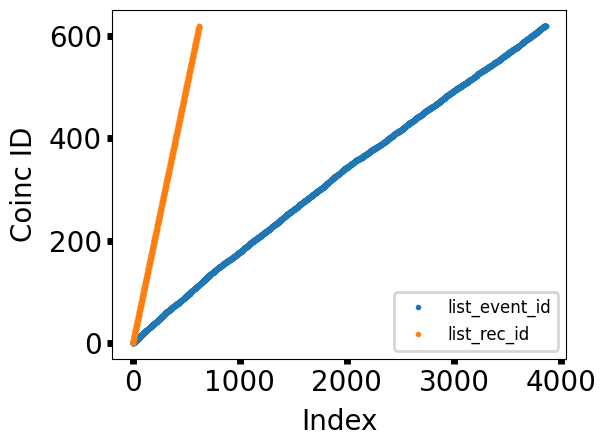

In [3]:
# Clean up tables
list_event_t_true = (list_coin_table[:,2] * 1e9).astype(np.int64) 
#+ list_event_nanos0 + list_event_sec0 * 1e9
plt.plot(list_event_id,'.',label='list_event_id')
plt.plot(list_rec_id,'.',label='list_rec_id')
plt.legend(loc='best')
plt.xlabel('Index')
plt.ylabel('Coinc ID')
print(len(list_event_id),"events,",int(max(list_event_id)),"coincs and",len(list_rec_id),"reconstructed coincs (mult>3)." )
dur_true = list_event_sec0[-1]-list_event_sec0[0]

plt.show()



## Chi2

0 / 621 ...
100 / 621 ...
200 / 621 ...
300 / 621 ...


<Figure size 640x480 with 0 Axes>

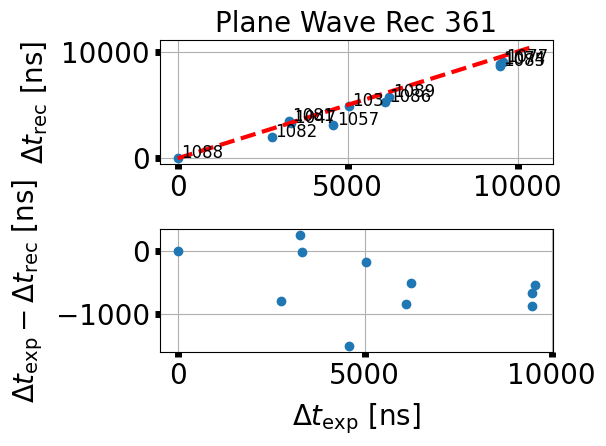

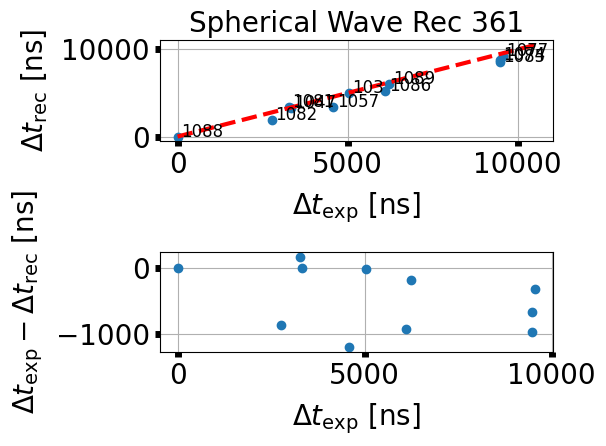

Event 361
Chi2 plan =  5970.193348998803 (theta,phi)= [ 89.6615 113.504 ]
Chi2 sph =  5655.391495234482 (x,y,z)= [-2424.3  -9564.05  1217.88]
400 / 621 ...


<Figure size 640x480 with 0 Axes>

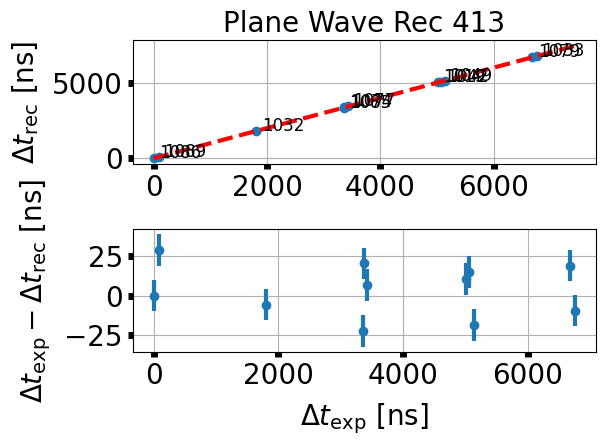

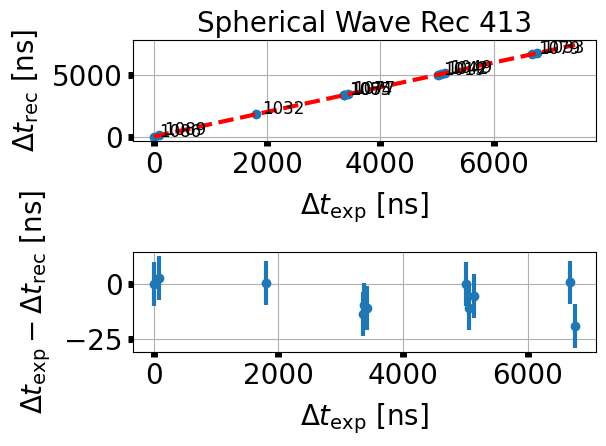

Event 413
Chi2 plan =  3.312347908946023 (theta,phi)= [ 93.8641 118.534 ]
Chi2 sph =  1.122605510451314 (x,y,z)= [  4584.32 -19434.2    1137.97]


<Figure size 640x480 with 0 Axes>

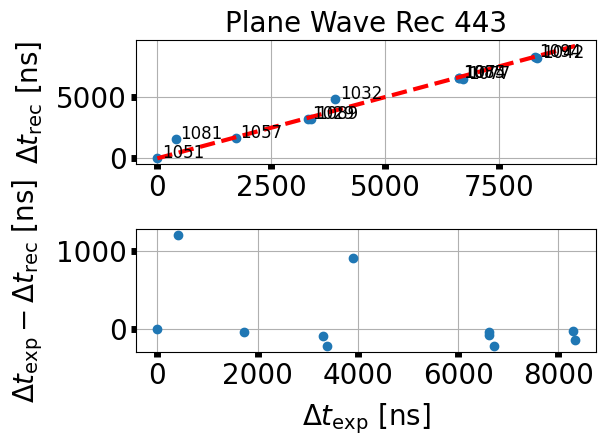

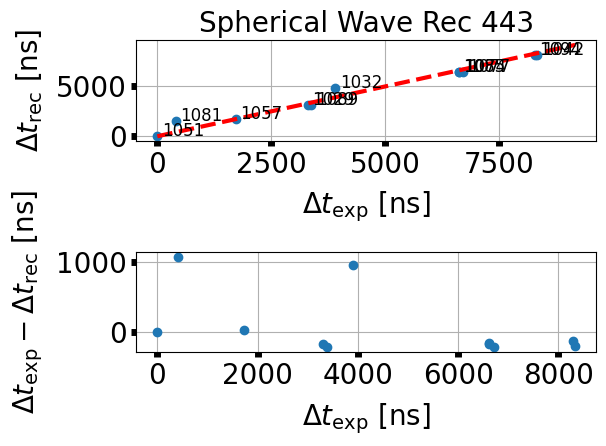

Event 443
Chi2 plan =  2632.941200386099 (theta,phi)= [ 89.3937 121.283 ]
Chi2 sph =  2900.2902773339547 (x,y,z)= [  4799.5  -19387.     1052.39]
500 / 621 ...


<Figure size 640x480 with 0 Axes>

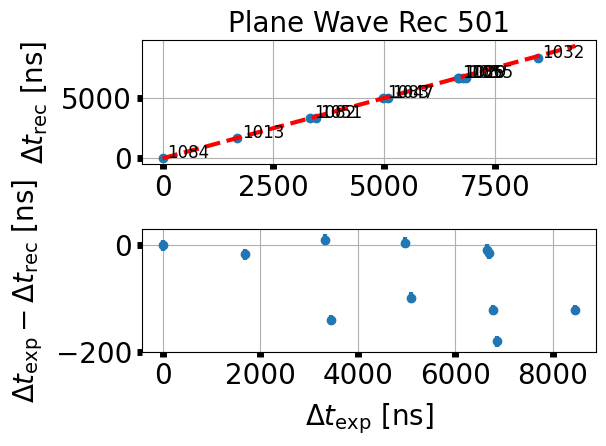

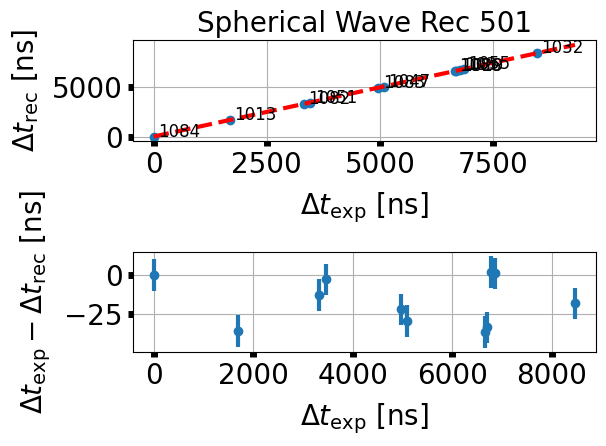

Event 501
Chi2 plan =  102.1237054118989 (theta,phi)= [ 88.891 119.859]
Chi2 sph =  6.894440588986676 (x,y,z)= [  4471.14 -19362.7    2257.14]


<Figure size 640x480 with 0 Axes>

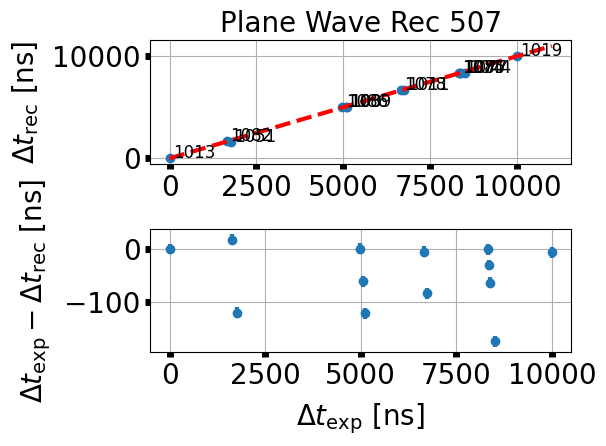

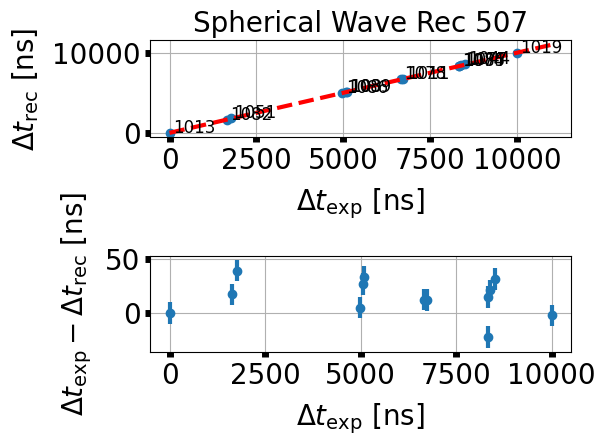

Event 507
Chi2 plan =  67.55076206685636 (theta,phi)= [ 86.5414 119.776 ]
Chi2 sph =  6.091331246237332 (x,y,z)= [  4466.05 -19420.4    1703.79]


<Figure size 640x480 with 0 Axes>

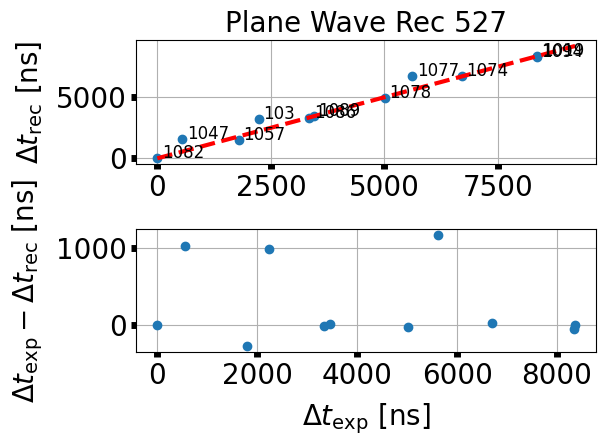

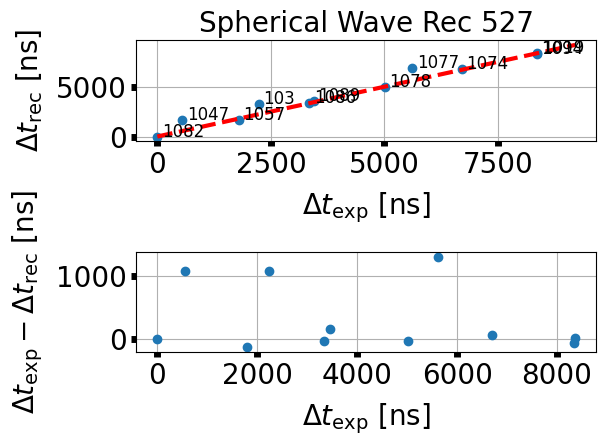

Event 527
Chi2 plan =  3839.445927062032 (theta,phi)= [ 90.1437 118.311 ]
Chi2 sph =  5028.7120010525305 (x,y,z)= [  3657.36 -19634.6    1052.44]
600 / 621 ...


In [4]:
list_chi2 = np.zeros(len(list_rec_id))
list_chi2_swf = -1e3*np.ones(len(list_rec_id))
diff_all = np.zeros((len(list_rec_id),len(list_DU_id_unique)))
diff_all_swf = -1e3*np.ones((len(list_rec_id),len(list_DU_id_unique)))
ttrig_all = np.zeros((len(list_rec_id),len(list_DU_id_unique)))

do_plot = 1

for i, event_id in enumerate(list_rec_id):
  if int(i/100) == i/100:
    print(i,"/",len(list_rec_id),"...")
  # Select proper lines both in coinc and recons files 
  mask_event = list_event_id == event_id
  #ind_rec = list_rec_id == event_id
  #list_linenumber = list_coin_table[mask_event,0]
  if (i>1) & (sum(mask_event)<4):
    print("Error! Should not be here")
    print(i,event_id,list_coin_table[mask_event,1:3])
    break
  time_delay_exp = list_coin_table[mask_event,2]
  time_delay_exp_ns = time_delay_exp * 1e9
  time_delay_exp_ns0 = time_delay_exp_ns - time_delay_exp_ns.min()
  argmin = np.argmin(time_delay_exp_ns0)
  mask_sort_time_delay = np.argsort(time_delay_exp_ns0)
  
  # PWF 
  rec_theta, rec_phi = np.radians(list_rec_plane[i,[2,4]]) # Reconstructed direction of the source
  du_pos = list_DU_coord[mask_event,1:]
  du_id = list_DU_id[mask_event]
  a,ar1,ar2 = np.intersect1d(du_id,list_DU_id_unique,return_indices=True)
  event_coord_shower_axis = np.dot(du_pos, [np.sin(rec_theta) * np.cos(rec_phi), np.sin(rec_theta) * np.sin(rec_phi), np.cos(rec_theta)]) 
  time_delay_rec =  event_coord_shower_axis / 3e8 * 1e9 # in nanoseconds
  # use the first triggered DU as the time origin
  time_offset = time_delay_exp_ns0[mask_sort_time_delay][0] - time_delay_rec[mask_sort_time_delay][argmin]
  chi2 = np.sum((time_delay_exp_ns0[mask_sort_time_delay] - (time_delay_rec[mask_sort_time_delay] + time_offset))**2) / (len(time_delay_exp) - 2) / 10**2  
  diff = (time_delay_rec + time_offset-time_delay_exp_ns0)
  diff_all[i,ar2] = diff
  ttrig_all[i,ar2] = time_delay_exp_ns0 
  if chi2 == np.nan:
      print(i, event_id)
      break 
  list_chi2[i] = chi2

  # SWF
  source_pos = list_rec_sphere[i,4:7]
  time_delay_sph  = np.linalg.norm(du_pos-source_pos,axis=1)/ 3e8 * 1e9 # in nanoseconds
  # use the first triggered DU as the time origin
  time_offset_sph = time_delay_exp_ns0[mask_sort_time_delay][0] - time_delay_sph[mask_sort_time_delay][argmin]
  chi2sph = np.sum((time_delay_exp_ns0[mask_sort_time_delay] - (time_delay_sph[mask_sort_time_delay] + time_offset_sph))**2) / (len(time_delay_exp) - 3) / 10**2  
  diff_swf = (time_delay_sph + time_offset_sph-time_delay_exp_ns0)
  diff_all_swf[i,ar2] = diff_swf
  if chi2 == np.nan:
      print(i, event_id)
      break 
  list_chi2_swf[i] = chi2sph
  if (do_plot == 1) & (sum(mask_event)>10):
    plt.clf()  
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(time_delay_exp_ns0[mask_sort_time_delay], time_delay_rec[mask_sort_time_delay] + time_offset, marker='o', ls='')
    # plt.axis("equal")
    plt.plot(np.array([0, max(time_delay_exp_ns0)*1.1]), np.array([0, max(time_delay_exp_ns0)*1.1]), ls='--', color='r')
    plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
    plt.title(f"Plane Wave Rec {event_id:.0f}")
    for j in range(len(time_delay_exp)):
        plt.text(time_delay_exp_ns0[mask_sort_time_delay[j]]+100, time_delay_rec[mask_sort_time_delay[j]] + time_offset,du_id[j],fontsize=12)
    plt.grid(True)
    plt.subplot(2,1,2)
    plt.errorbar(time_delay_exp_ns0[mask_sort_time_delay], diff, 10*np.ones((len(mask_sort_time_delay))), marker='o', ls='')
    plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
    plt.ylabel(r"$\Delta t_{\rm exp} - \Delta t_{\rm rec} $ [ns]")
    plt.tight_layout()   
    plt.grid(True)
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(time_delay_exp_ns0[mask_sort_time_delay], time_delay_sph[mask_sort_time_delay] + time_offset_sph, marker='o', ls='')
    # plt.axis("equal")
    plt.plot(np.array([0, max(time_delay_exp_ns0)*1.1]), np.array([0, max(time_delay_exp_ns0)*1.1]), ls='--', color='r')
    plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
    plt.ylabel(r"$\Delta t_{\rm rec} $ [ns]")
    plt.title(f"Spherical Wave Rec {event_id:.0f}")
    for j in range(len(time_delay_exp)):
        plt.text(time_delay_exp_ns0[mask_sort_time_delay[j]]+100, time_delay_sph[mask_sort_time_delay[j]] + time_offset_sph,du_id[j],fontsize=12)
    plt.grid(True)
    plt.subplot(2,1,2)
    plt.errorbar(time_delay_exp_ns0[mask_sort_time_delay], diff_swf, 10*np.ones((len(mask_sort_time_delay))), marker='o', ls='')
    plt.ylabel(r"$\Delta t_{\rm exp} - \Delta t_{\rm rec} $ [ns]")
    plt.xlabel(r"$\Delta t_{\rm exp} $ [ns]")
    plt.tight_layout()   
    plt.grid(True)
    plt.tight_layout()   
    plt.show();
    print("Event",int(event_id))
    print("Chi2 plan = ",chi2,"(theta,phi)=",list_rec_plane[i,[2,4]])
    print("Chi2 sph = ",chi2sph,"(x,y,z)=",source_pos)
#    plt.savefig(f"imgs/0616/delay_plane_{event_id:.0f}.pdf")


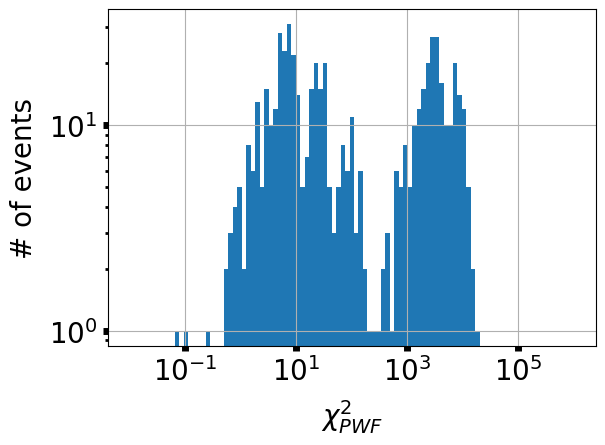

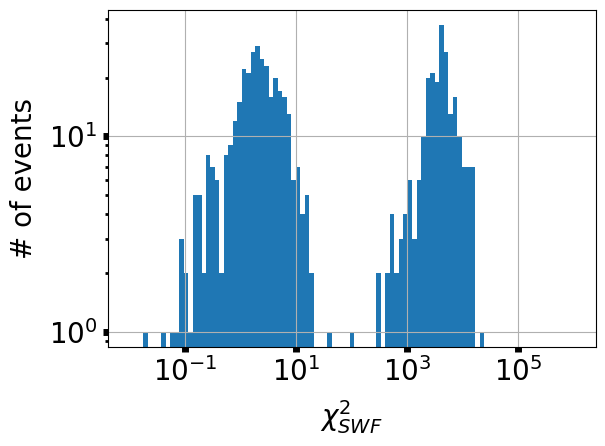

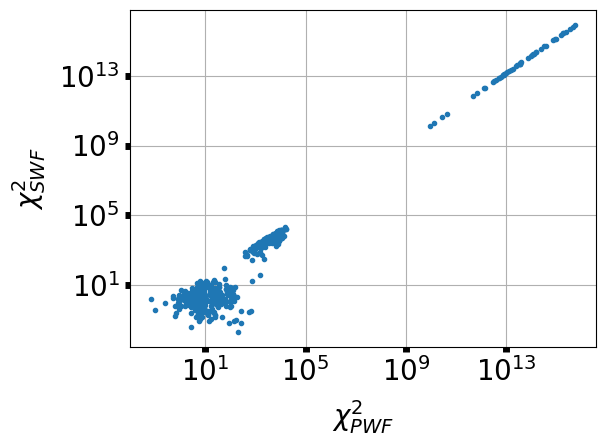

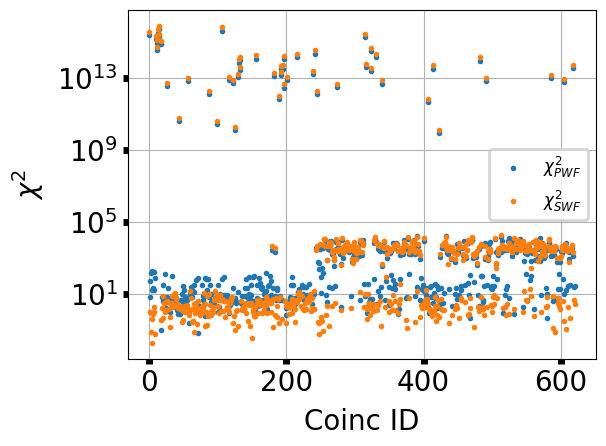

In [5]:
plt.hist(list_chi2, np.logspace(-2, 6, 100));
# plt.axvline(1e7)
plt.ylabel("# of events")
plt.xlabel("$\chi^2_{PWF}$")
plt.grid()
plt.loglog()

plt.figure()
plt.hist(list_chi2_swf, np.logspace(-2, 6, 100));
# plt.axvline(1e7)
plt.ylabel("# of events")
plt.xlabel("$\chi^2_{SWF}$")
plt.grid()
plt.loglog()

plt.figure()
plt.plot(list_chi2,list_chi2_swf,'.')
plt.xlabel("$\chi^2_{PWF}$")
plt.ylabel("$\chi^2_{SWF}$")
plt.grid()
plt.loglog()

plt.figure()
plt.plot(list_chi2,'.',label='$\chi^2_{PWF}$')
plt.plot(list_chi2_swf,'.',label='$\chi^2_{SWF}$')
plt.legend(loc="best")
plt.semilogy()
plt.xlabel("Coinc ID")
plt.ylabel("$\chi^2$")
plt.grid()

## Delays

DU 1013 : -134.69602413823833 +- 195.37256317737396 ns
DU 1019 : -9565182.98452484 +- 53527312.50023898 ns
DU 1020 : 56.47554973620324 +- 584.0617942274017 ns
DU 1029 : -1312939.2631652656 +- 12103454.774872351 ns
DU 1032 : -24327401.27181778 +- 96245128.35813685 ns
DU 1033 : -6745614.251740813 +- 55743136.24793303 ns
DU 1042 : -247069.33512303582 +- 2356379.510150062 ns
DU 1044 : -10482001.120690972 +- 26021871.748765085 ns
DU 1047 : -154.45614387691973 +- 460.59051981662606 ns
DU 1049 : -6532534.606614952 +- 51442806.794465154 ns
DU 1051 : -87.14414263782173 +- 290.1922613134365 ns
DU 1052 : -41911505.614219755 +- 148189994.73617214 ns
DU 1054 : -35062377.31939265 +- 44067229.133643515 ns
DU 1055 : -34668876.08038908 +- 54102630.011717774 ns
DU 1057 : -190581.12229892658 +- 1922900.4608783317 ns
DU 1074 : -2677968.3554353965 +- 34401526.530129515 ns
DU 1075 : -39863120.761271715 +- 44289561.72387296 ns
DU 1077 : -5249370.574452932 +- 33052319.10825855 ns
DU 1078 : -139.41326194100168

/tmp/ipykernel_19365/2022685643.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(id)


DU 1082 : -404014.4230080232 +- 4825609.857462853 ns
DU 1083 : -35069176.26936979 +- 101279574.74295591 ns
DU 1084 : -15018850.172723398 +- 96700432.1733477 ns
DU 1085 : -1138090.1356560823 +- 14054596.548677798 ns
DU 1086 : -10000483.236444298 +- 75757656.82699744 ns
DU 1088 : -4686128.10928677 +- 42141325.95937882 ns
DU 1089 : -3913142.088267329 +- 41124352.961291574 ns
DU 1094 : -7273494.355057522 +- 47837733.96648678 ns


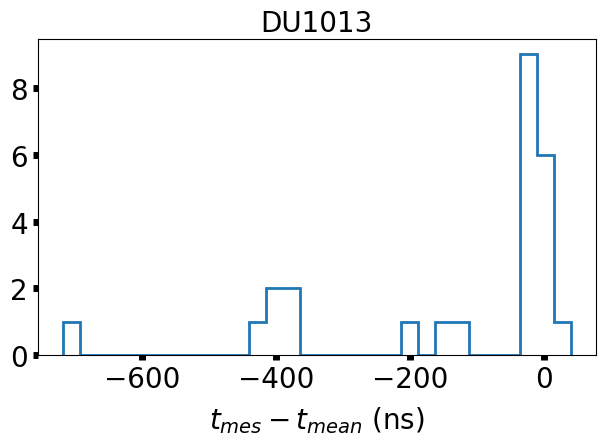

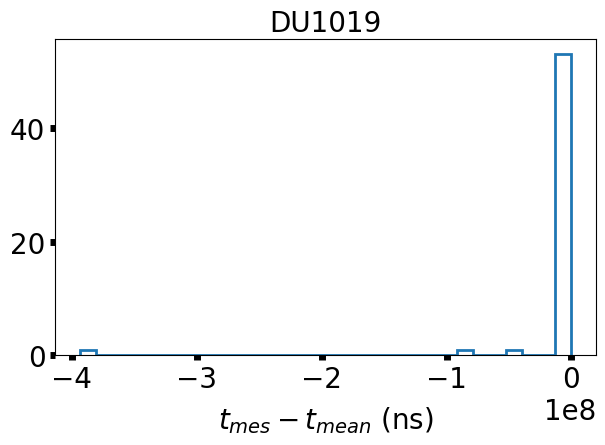

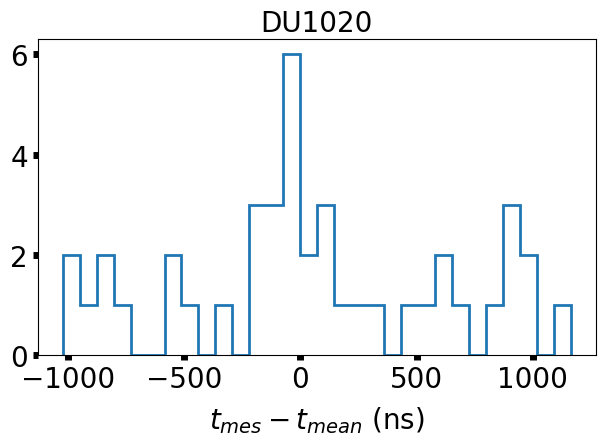

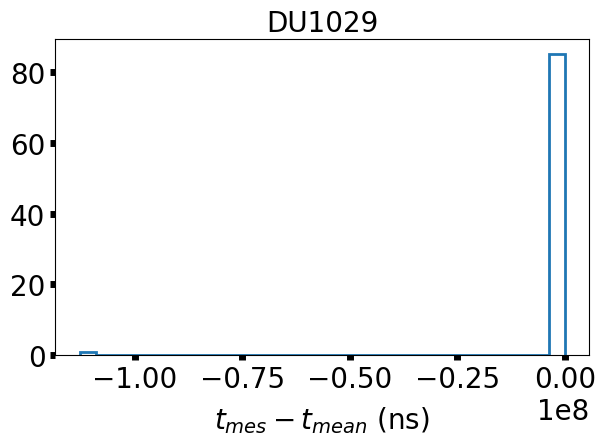

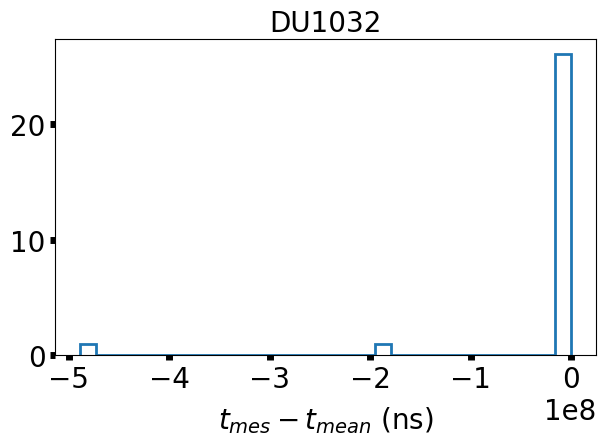

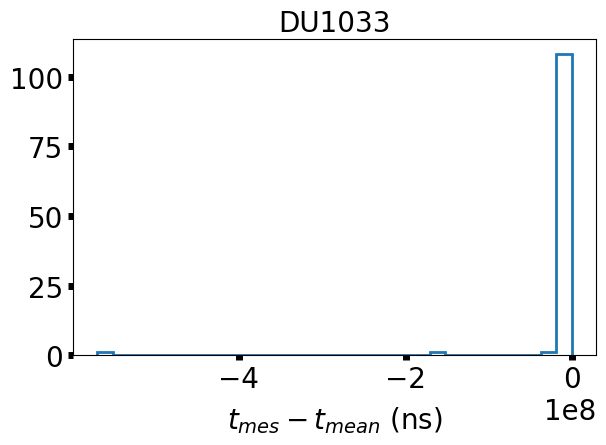

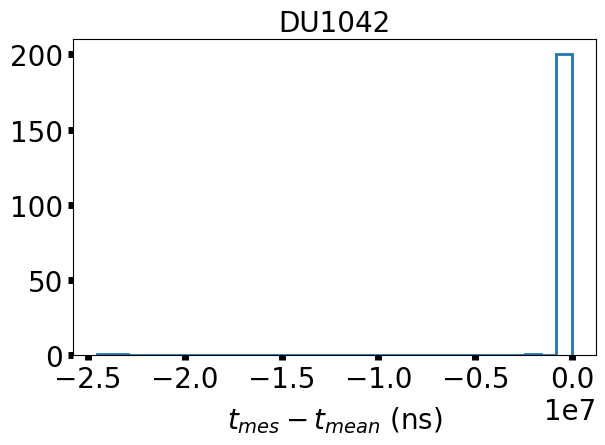

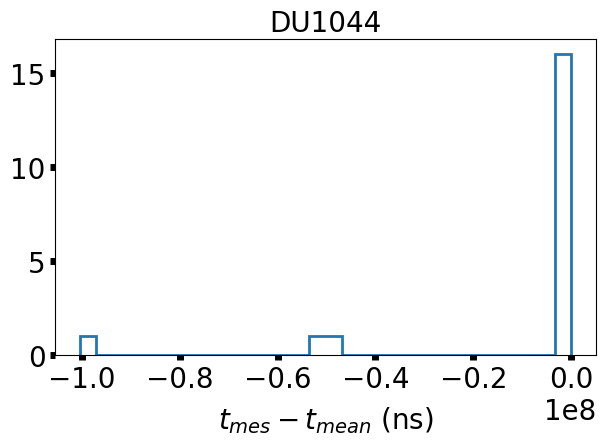

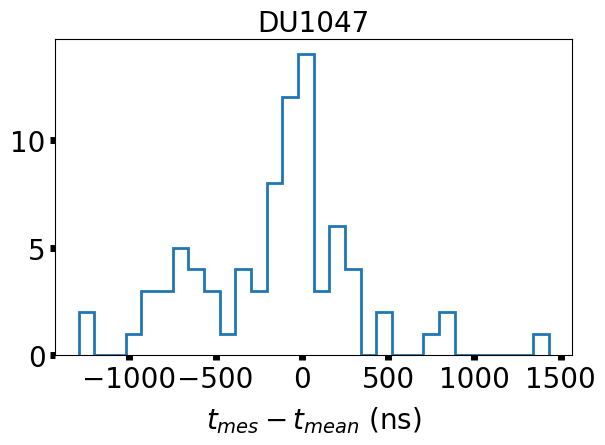

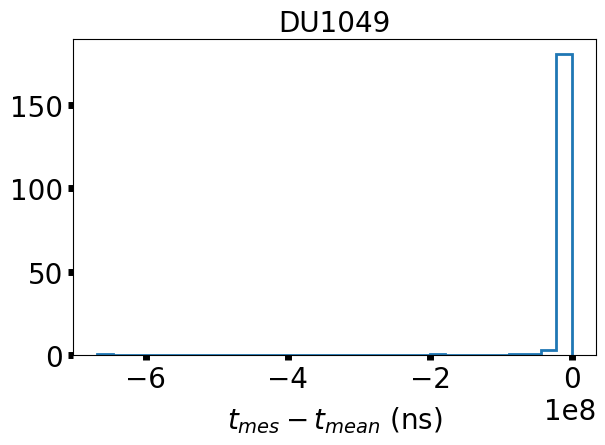

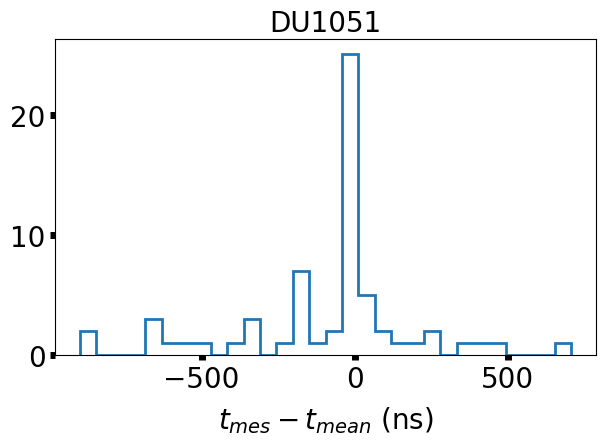

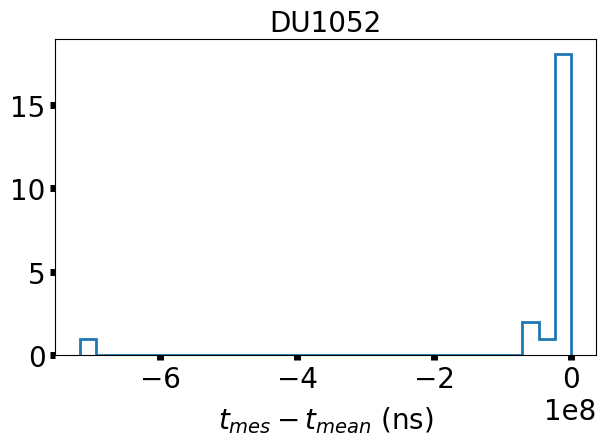

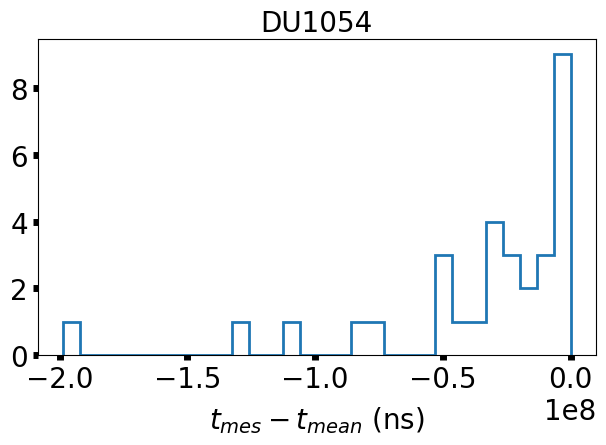

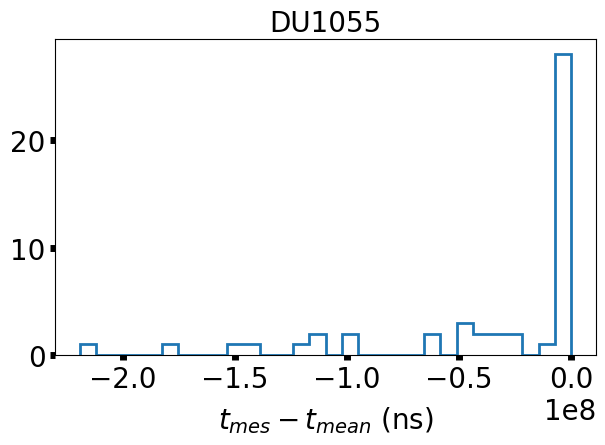

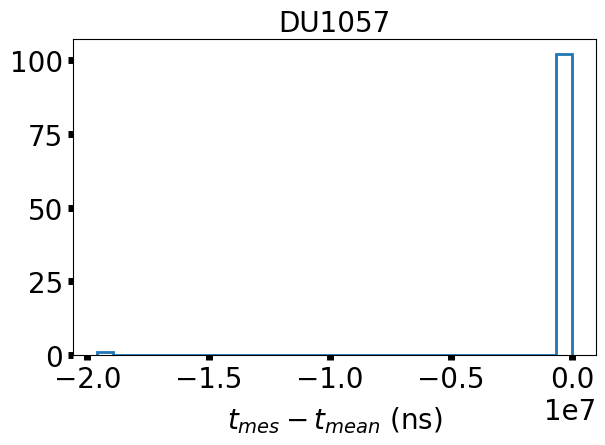

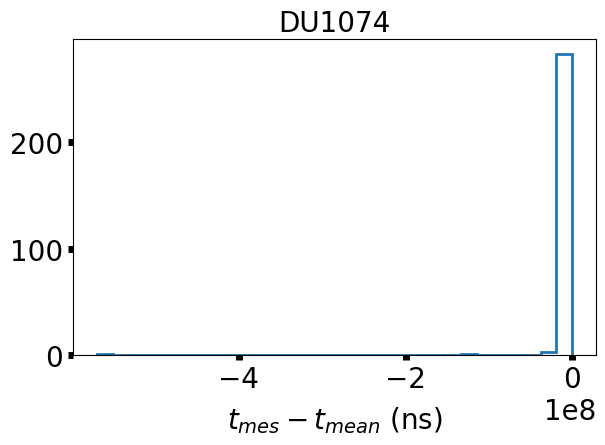

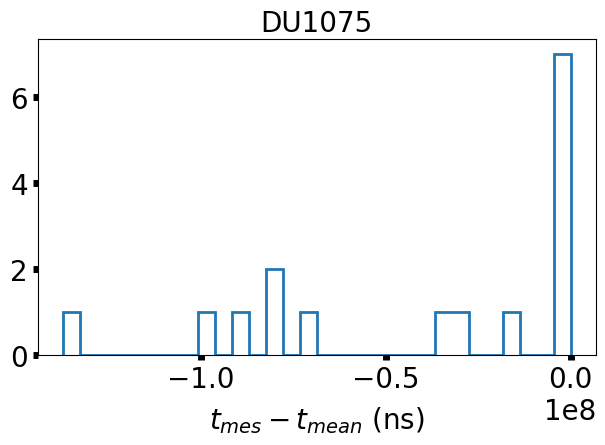

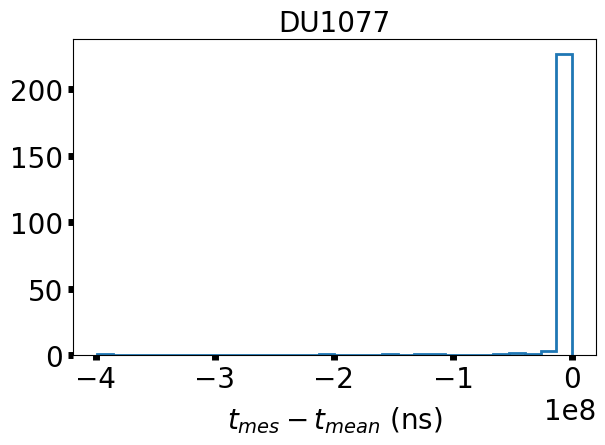

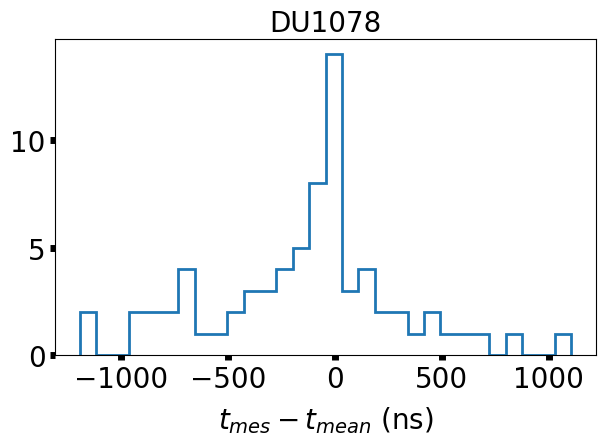

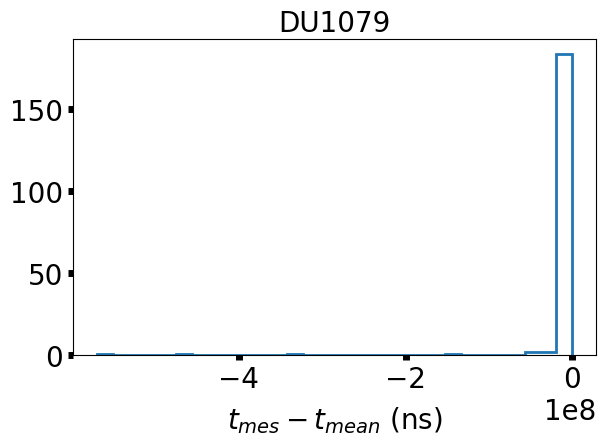

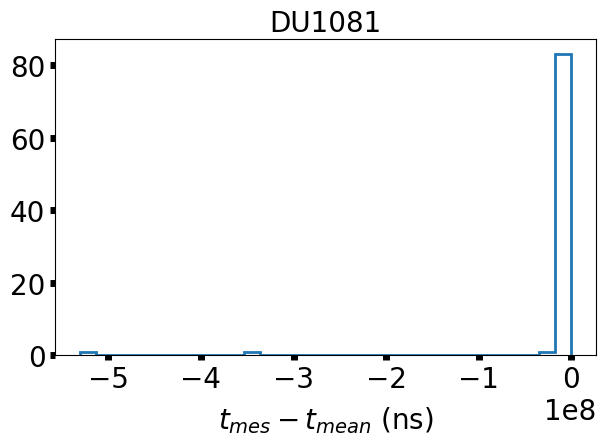

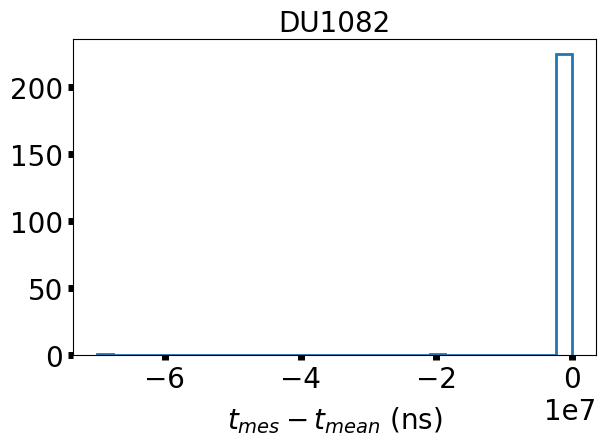

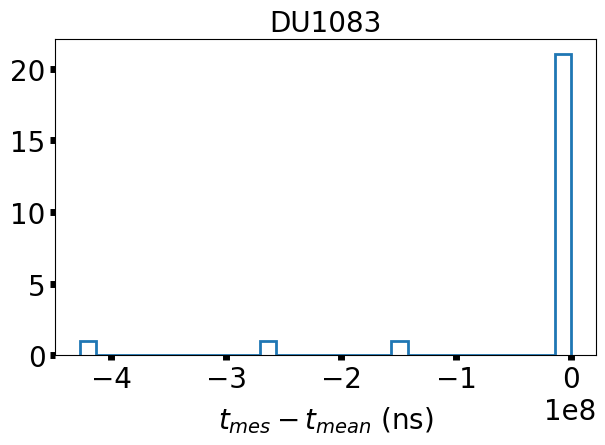

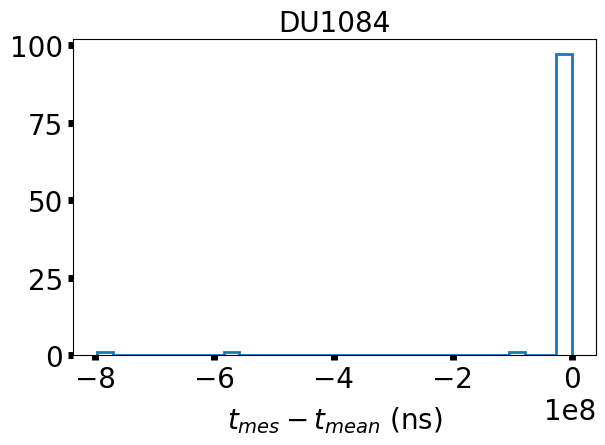

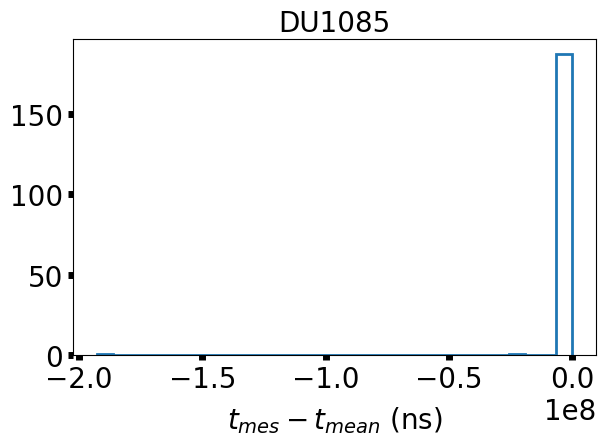

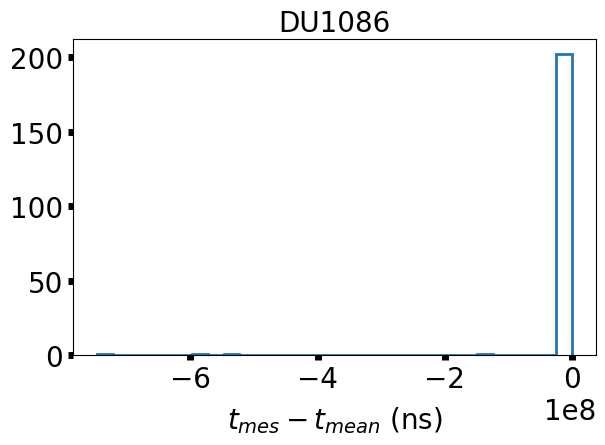

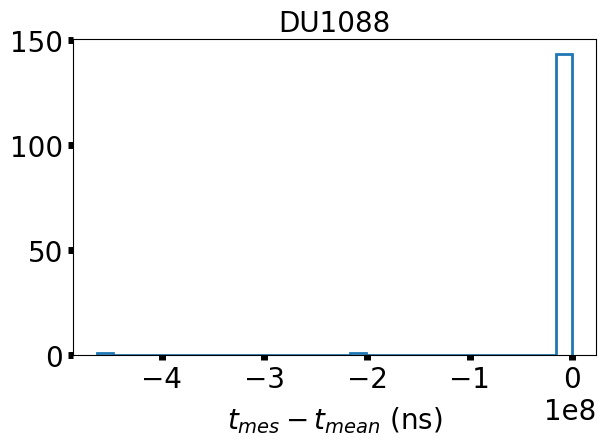

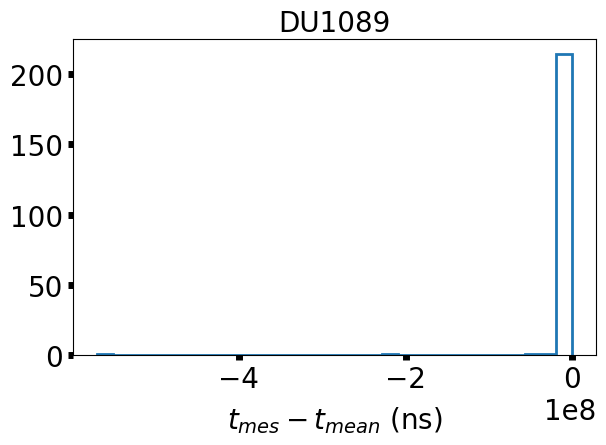

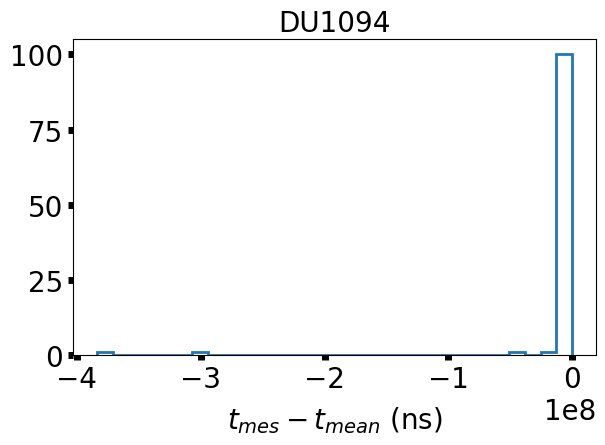

In [6]:
list_event_id_unique, mask_unique, list_n_du = np.unique(list_event_id, return_index=True, return_counts=True)
for i,id in enumerate(list_DU_id_unique):
  sel = (diff_all_swf[:,i]!=-1e3) & (diff_all_swf[:,i]!=0) 
#& sel_beacon
  sel2 = (ttrig_all[:,i]>0) 
    #& (sel_beacon==1) & (list_n_du >6)
  if np.sum(sel)>9:
        plt.figure(id)
        print("DU",id,":",np.mean(diff_all_swf[sel,i]),"+-",np.std(diff_all_swf[sel,i]),"ns")
        plt.hist(diff_all_swf[sel,i],30,histtype='step');
        plt.xlabel('$t_{mes}-t_{mean}$ (ns)');
        plt.title("DU"+str(id))
        
        #plt.figure()
        #plt.hist(ttrig_all[sel2,i],30,histtype='step');
        #plt.xlabel('$t_{mes}$ (ns)');

#plt.semilogy()


        

## Positions / refs

[14.376   9.6813  8.216   3.1682  0.     21.2376 17.5424  8.5299 20.
 15.248  26.552  28.     24.6    18.976 ]
[ 7.08735  7.40035 21.487   11.97125 26.84225  0.      22.93835 22.68035
 35.03395 39.68245]
-52.06594142857125
[[ 7.04991149e-10 -5.67923126e-12  3.75999999e-01]
 [-4.09141669e+02 -4.54125160e+02 -4.36724506e+00]
 [-6.84963684e+02 -9.07559173e+02 -5.92073766e+00]
 [-5.00938523e+02 -1.41015888e+03 -1.10492094e+01]
 [-6.87770881e+02 -1.75258856e+03 -1.43313251e+01]
 [-1.16741414e+03 -9.07901480e+00  7.10344081e+00]
 [-1.08703857e+03 -8.81165144e+02  3.34470567e+00]
 [-1.24757139e+03 -1.72024868e+03 -5.88991168e+00]
 [-1.42549430e+03 -4.65925547e+02  5.78046561e+00]
 [-1.44721962e+03 -1.28914399e+03  8.92190835e-01]
 [-1.94641143e+03 -4.30147053e+02  1.21857621e+01]
 [-2.14003657e+03 -8.79529516e+02  1.35113774e+01]
 [-1.93933265e+03 -1.35530473e+03  1.00868243e+01]
 [-6.66480511e+02 -2.97167115e+01  4.92504152e+00]]


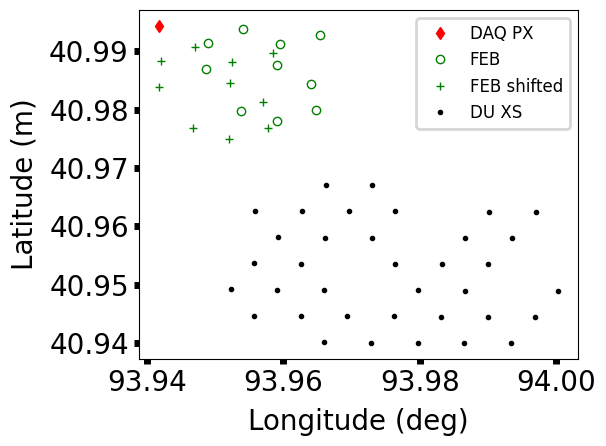

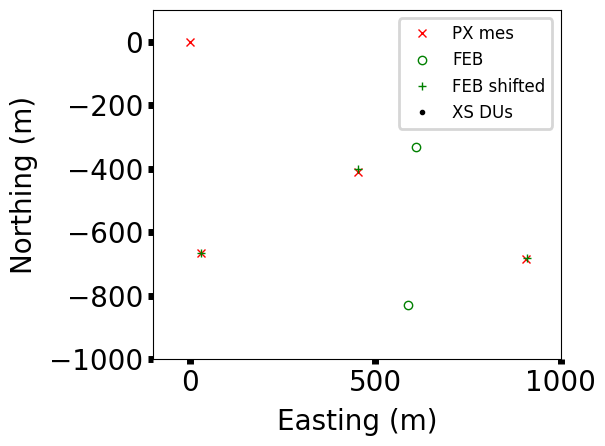

In [9]:
from grand import (
    Coordinates,
    CartesianRepresentation,
    SphericalRepresentation,
    GeodeticRepresentation,
)
from grand import ECEF, Geodetic, GRANDCS, LTP
from grand import Geomagnet
from grand import Topography, Reference, geoid_undulation
from grand import topography

#daq_lat = 40+59/60+39/3600
#daq_lon = 93+56/60+30/3600
#daq   = Geodetic(latitude=daq_lat, longitude=daq_lon, height=1262)   #  From Google Maps
daq   = Geodetic(latitude=40.99434, longitude=93.94177, height=1262)   # lat, lon of the center station (from PengXiong)

#a = np.genfromtxt("/home/olivier/GRAND/GP300/ana/GP13/gp13_gps.txt") # Read GPS values recorded by Fred
#du_gps = a[:,0]
#lat_gps = a[:,1]
#lon_gps = a[:,2]
#alt_gps = a[:,3]

#From PengXiong
du = np.array([[93.94177, 40.99434,  1262.3760]])
du = np.append(du,[[93.94717,  40.99066,  1257.6813]],axis=0)  
du = np.append(du,[[93.95256,  40.98818, 1256.2160]],axis=0)  
du = np.append(du,[[93.95853,  40.98984, 1251.1682]],axis=0)  
du = np.append(du,[[93.96260,  40.98816, 1248.0000]],axis=0)  
du = np.append(du,[[93.94189,  40.98383, 1269.2376]],axis=0)  
du = np.append(du,[[93.95225,  40.98456, 1265.5424]],axis=0)  
du = np.append(du,[[93.96222,  40.98312, 1256.5299]],axis=0)  
du = np.append(du,[[93.94732,  40.98151,  1268.0000]],axis=0)  
du = np.append(du,[[93.95710,  40.98132, 1263.2480]],axis=0)  
du = np.append(du,[[93.94690,  40.97682,  1274.5520]],axis=0)  
du = np.append(du,[[93.95224,  40.97508, 1276.0000]],axis=0)
du = np.append(du,[[93.95789,  40.97689, 1272.6000]],axis=0)
du = np.append(du,[[93.94213,  40.98834,  1266.9760]],axis=0)
lon_px = du[:,0]
lat_px = du[:,1]
alt_px = du[:,2]
print(alt_px-min(alt_px))
# From FEB:
feb_lon = np.array([93.95949423, 93.95408339, 93.9487553,  93.94903341, 93.96481165, 93.965454, 93.95916533, 93.96402053, 93.95381051, 93.95914872])
feb_lat = np.array([40.99121999, 40.99372614, 40.98687089, 40.99135205, 40.97992482, 40.99282103, 40.98757751, 40.98437015, 40.97984428, 40.97810358])
feb_alt = np.array([1198.94675, 1199.25975, 1213.3464,  1203.83065, 1218.70165, 1191.8594, 1214.79775, 1214.53975, 1226.89335, 1231.54185])
print(feb_alt-min(feb_alt))
print(np.mean(feb_alt)-np.mean(alt_px))
plt.figure(1)
#plt.plot(lon_gps,lat_gps,'ob',label='Antennas-gp13-coord-gpx.xml')
plt.plot(daq.longitude,daq.latitude,'dr',label='DAQ PX')


plt.plot(feb_lon,feb_lat,'og',markerfacecolor='w',label='FEB')
#plt.plot(daq_lon,daq_lat,'^r',label='DAQ Google Maps')
#plt.plot(lon_gps[du_gps==0],lat_gps[du_gps==0],'or',label='Antennas-gp13-coord-gpx.xml')


# Now to GRAND CS
dus_px = Geodetic(latitude=lat_px, longitude=lon_px, height=alt_px)
dus_px = GRANDCS(dus_px, obstime="2024-09-15", location=daq)
dus_feb = Geodetic(latitude=feb_lat, longitude=feb_lon, height=feb_alt)
dus_feb = GRANDCS(dus_feb, obstime="2024-09-15", location=daq)
offset = np.array([-333, 582, +52])  # From Xishui FEB ==> GPS  #333, 584
dus_shift = np.array([dus_feb.x+offset[0], dus_feb.y+offset[1],dus_feb.z+offset[2]])
dus_shift = GRANDCS(x=dus_shift[0], y=dus_shift[1], z=dus_shift[2], location=daq)
# Switch back to Geoid for check
shift_geo = Geodetic(dus_shift)
#dus_cs = GRANDCS(dus_geo, obstime="2024-09-15", location=daq)
plt.plot(shift_geo.longitude,shift_geo.latitude,'+g',label='FEB shifted')


plt.figure(2)
plt.plot(-dus_px[1],dus_px[0],'xr',label='PX mes')  # PengXiong pos
plt.plot(-dus_feb[1],dus_feb[0],'og',markerfacecolor='w',label='FEB')  # FEB pos
print(dus_px.T)
plt.plot(-dus_shift[1],dus_shift[0],'+g',label='FEB shifted')  # FEB pos

#Shift phone GPS towards West by 584 and towards South by 334
#print(-dus_cs[1][du_gps==0],dus_cs[0][du_gps==0])  # Position from FEB GPS... But how come this matches the origin for FEB data??
zdu,ind_dus = np.unique(list_DU_coord[:,3], return_index=True)
xdu = list_DU_coord[ind_dus,1]
ydu = list_DU_coord[ind_dus,2]
dus_xs = GRANDCS(x=xdu, y=ydu, z=zdu, location=daq)
geo_xs = Geodetic(dus_xs)
plt.figure(1)
plt.plot(geo_xs.longitude,geo_xs.latitude,'.k',label='DU XS')
plt.legend(loc = 'best')
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (m)")
plt.figure(2)
plt.plot(-ydu,xdu, '.k',label='XS DUs')

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend(loc='best')
#plt.xlim([850,920])
#plt.xlim([450,460])
plt.xlim([-100,1000])
plt.ylim([-1000,100])


# Now apply correction to mine
mine   = Geodetic(latitude=41.00861, longitude=94.09972, height=1230)   # lat, lon of the mine (Google Earth)
mine_tower   = Geodetic(latitude=41.01083, longitude=94.09583, height=1230)   # lat, lon of the mine (Google Earth)
mine_power   = Geodetic(latitude=41.0120891, longitude=94.094362, height=1230)   # lat, lon of the mine (Google Earth)
#du21   = Geodetic(latitude=40.98614, longitude=93.96915, height=1205)   # lat, lon of DU21 (from FEB)
mine_cs = GRANDCS(mine, obstime="2024-09-15", location=daq).T[0]
minet_cs = GRANDCS(mine_tower, obstime="2024-09-15", location=daq).T[0]
minep_cs = GRANDCS(mine_power, obstime="2024-09-15", location=daq).T[0]

#print(minep_cs)
#print(mine_cs)
#mine_cs = GRANDCS(mine, obstime="2024-09-15", location=du21)
#print(mine_cs)
#Old DAQ: 40.99434° N, 93.94177° E
#New DAQ: 40.95541° N, 93.97299° E
#Mine 41°00'31"N 94°05'59"E
#print(42/3600)
#print(5/60+39/3600)

## Plane recons

Selection ratio 0.47665056360708535
Beacon source: 10 / 11309 s =  0.0008842514811212309 Hz
Background source: 505 / 11309 s =  0.044654699796622156 Hz


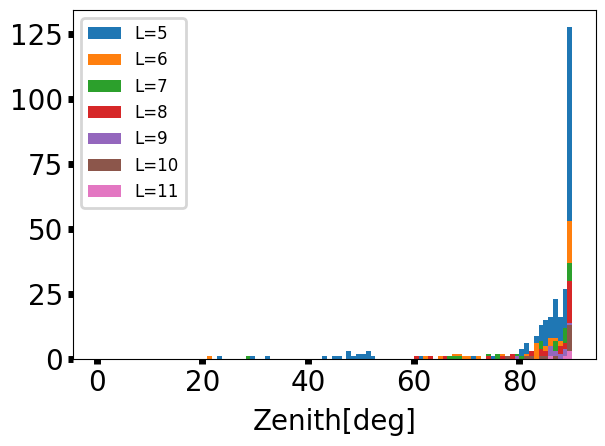

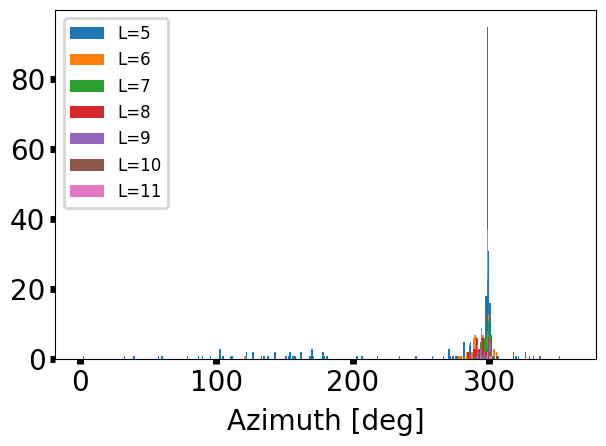

In [15]:
mult = list_rec_plane[:,1].copy()
sel = (list_chi2<50) & (mult>4)
print("Selection ratio",sum(sel)/len(mult))

zenith_wrapped_around_horizon = list_rec_plane[:,2].copy()
zenith_wrapped_around_horizon = 180 - zenith_wrapped_around_horizon
zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] = 90 - (zenith_wrapped_around_horizon[zenith_wrapped_around_horizon > 90] - 90)
azimuth = list_rec_plane[:,4] + 180
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360

for mult in range(max(list_n_du)):
  mask_mult = list_n_du == mult
  if sum(mask_mult) == 0:
        continue
  plt.figure(1)
  plt.hist(zenith_wrapped_around_horizon[~sel_beacon & mask_mult],bins=np.linspace(00,90,100),label='L='+str(mult));
  plt.xlabel("Zenith[deg]")
  #plt.semilogy()
  plt.figure(2)
  plt.hist(azimuth[~sel_beacon & mask_mult],bins=np.linspace(0,360,360),label='L='+str(mult));
  #plt.xlim([286,290])
  #plt.semilogy()
  plt.xlabel("Azimuth [deg]")
plt.figure(1)
plt.legend(loc="best")
plt.figure(2)
plt.legend(loc="best")
print("Beacon source:",np.sum( (azimuth>0) & (azimuth<100)),"/",dur_true,"s = ",np.sum( (azimuth>0) & (azimuth<100))/dur_true,"Hz")
print("Background source:",np.sum( (azimuth>200) & (azimuth<300)),"/",dur_true,"s = ",np.sum( (azimuth>200) & (azimuth<300))/dur_true,"Hz")


## Skyplot

621 3858 621


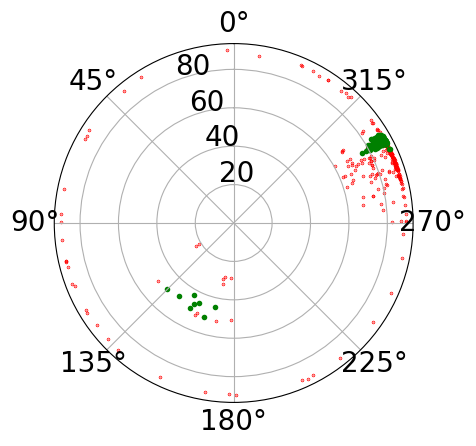

In [11]:

print(len(list_event_id_unique),len(list_event_id),len(azimuth))
n_min = list_event_t_true[mask_unique] // 1e9 // 60
plt.polar()
#c=(n_min - n_min[0]), cmap="gnuplot"
plt.scatter(azimuth * np.pi / 180, zenith_wrapped_around_horizon, marker='.', ls='-', s=1, c='r')
plt.scatter(azimuth[sel] * np.pi / 180, zenith_wrapped_around_horizon[sel], marker='o', ls='-', s=4, c='g')

plt.gca().set_theta_zero_location('N', offset=0)
#plt.colorbar(location='right', label='Min')

## Spherical recons

ValueError: Unrecognized marker style '.g'

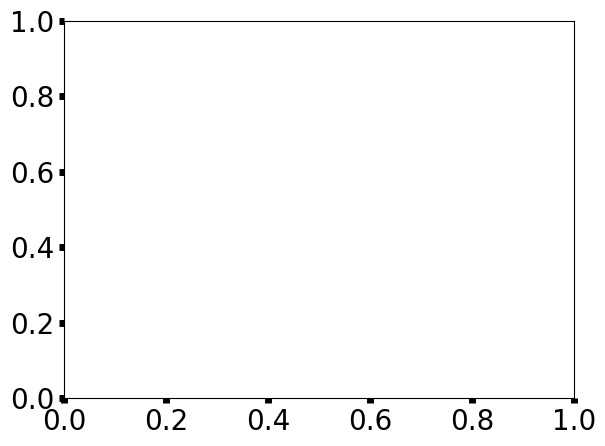

In [17]:
xs = list_rec_sphere[:,4].copy()
ys = list_rec_sphere[:,5].copy()
rho = list_rec_sphere[:,8].copy()
plt.figure()
sel_chi2 = list_chi2_swf<30
plt.plot(-ys[sel_chi2], xs[sel_chi2], marker='.g', ls='', markersize=2,label='Background')
sel_beacon = (rho>500) & (rho<1500) & (chi2sph<20)
# No need for cut on CHi2, all good.
print(sum(sel_beacon),"events from beacon.")
print(sum(~sel_beacon),"from background.")
plt.plot(-ys[sel_beacon], xs[sel_beacon], marker='.', ls='', markersize=2,label='Beacon')
plt.xlabel("Easting[m]")
plt.ylabel("Northing[m]")
dlim = 1e2

#beacon = 
#plt.xlim(-dlim, dlim)
#plt.ylim(-dlim, dlim)
#plt.ylim(-2500, 100)
#plt.xlim(-500, 2000)
#plt.ylim(1500, 2500)
#plt.xlim(10000, 14000)
if 1: # Display DU positions
  zdu,ind_dus = np.unique(list_DU_coord[:,3], return_index=True)
  xdu = list_DU_coord[ind_dus,1]
  ydu = list_DU_coord[ind_dus,2]
  plt.plot(-ydu,xdu, 'o')
print(minep_cs)
#plt.plot(-minep_cs[1],minep_cs[0],'dk',markersize=5,label='Mine Power Building')
#plt.plot(-minet_cs[1],minet_cs[0],'xg',markersize=5,label='Mine Comm Tower')
#plt.plot(-mine_cs[1],mine_cs[0],'hg',markersize=5,label='Mine')
#plt.legend(loc='best')
az = np.arctan2(minep_cs[1],minep_cs[0])*180/np.pi
print(az)
if az<0:
    az += 360
print(az)
plt.grid()
#plt.xlim(0, 14000)
#plt.axis('equal')


In [ ]:

ground_alt = list_rec_sphere[0,9]
zs = list_rec_sphere[:,6].copy()
zs[zs<ground_alt] = 2*ground_alt -  zs[zs<ground_alt]
plt.figure()
plt.plot(rho, list_rec_sphere[:,6], marker='s', ls='', markersize=1)
plt.plot(rho, zs, marker='s', ls='', markersize=1)
plt.axis("equal")
plt.xlabel("Distance to source[m]")
plt.ylabel("Height asl[m]")
plt.ylim(0,)
plt.plot([0,20000],[ground_alt, ground_alt],'--',linewidth=1)

plt.figure()
plt.hist(np.abs(list_rec_sphere[:,6]),200);
plt.hist(zs,200);
plt.plot([ground_alt, ground_alt],[0,500],'--',linewidth=1)
plt.xlabel("Height asl[m]")

plt.figure()
plt.hist(np.abs(rho[sel_beacon]),200,label="Beacon");
plt.hist(np.abs(rho[~sel_beacon]),200,label="Background");
plt.legend(loc="best")
#plt.semilogy()
#plt.xlim([0, 2000])
plt.xlabel("Distance to source [m]")

plt.figure()
#plt.subplot(1,3,1)
plt.hist(xs[sel_beacon],200,label="Beacon");
print("X (m):", np.mean(xs[sel_beacon]),"+-",np.std(xs[sel_beacon]))
plt.xlim([-100,100])
plt.xlabel("$X_{beacon}$ (m)")
plt.figure()
#plt.subplot(1,3,2)
plt.hist(ys[sel_beacon],200,label="Beacon");
plt.xlim([-100,100])
plt.xlabel("$Y_{beacon}$ (m)")
print("Y (m):", np.mean(ys[sel_beacon]),"+-",np.std(ys[sel_beacon]))
plt.figure()
#plt.subplot(1,3,3)
plt.hist(zs[sel_beacon],200,label="Beacon");
plt.xlim([ground_alt-10,ground_alt+300])
plt.xlabel("$Z_{beacon}$ (m)")

print("Z (m):", np.mean(zs[sel_beacon]),"+-",np.std(zs[sel_beacon]))


## Trigger time distribution

In [ ]:
# Get one time for each event

list_event_t_unique = list_event_t_true[mask_unique]
list_event_t_unique = list_event_t_unique
plt.plot(list_event_id_unique, list_event_t_unique, marker='.', ls='', markersize=1)
plt.xlim(0,)
plt.grid(True)
plt.xlabel("Event ID")
plt.ylabel("Timestamp[ns]")
print((list_event_t_unique[-1]-list_event_t_unique[0])/1e9)



## Negative dt

In [ ]:
x = np.diff(list_event_t_true[mask_unique])
print(list_event_id_unique[:-1][(x < 10e3)])
print(x[x < 10e3])

In [ ]:
mask_negative_event_id = (list_event_id_unique[:-1][(x < 10e3)])
for e_id in mask_negative_event_id:
    plt.figure()
    plt.title(int(e_id))
    _ = list_event_t_true[list_event_id == e_id]-list_event_t_true[list_event_id == e_id][0]
    __ = list_event_t_true[list_event_id == e_id+1]-list_event_t_true[list_event_id == e_id][0]
    plt.plot(_, marker='.')
    plt.plot(len(_) + np.arange(len(__)), __, marker='.')
    plt.axhline(1e4)
    # plt.axhline(1e4)

In [ ]:
list_t_diff = np.diff(list_event_t_unique)
plt.hist(list_t_diff, np.logspace(3, 13, 200))
plt.axvline(10e3, ls='--', c='k', zorder=100) 
plt.axvline(4e6, ls='--', c='r', zorder=100) # 160Hz
plt.axvline(9e7, ls='--', c='r', zorder=100) # 11Hz
plt.axvline(3e9, ls='--', c='r', zorder=100) # 1Hz
plt.axvline(2e11, ls='--', c='r', zorder=100) # 5E-3 Hz
# plt.axvline(86400e9, ls='--', c='k', zorder=100)
plt.loglog()
plt.xlabel("$\Delta t$[ns]")
plt.title("Distribution of event interval")
plt.grid(True);


## Multiplicity

In [ ]:
ndu, n = np.unique(list_n_du, return_counts=True)
print("Nb of events per mult")
print(ndu,n)
plt.bar(ndu, n, width=0.8)
plt.plot(np.arange(3,11), n[0] / np.power(10,0.5*(np.arange(3,11)-3)), zorder=100, ls='--', c='r')
plt.grid(True)
plt.semilogy()
plt.xticks(np.arange(1, 10))
plt.xlabel(r"$N_{\rm DU}$")
plt.ylabel(r"$N_{\rm event}$");


In [ ]:
timestamps_ns = list_event_t_unique
timestamps_s = (timestamps_ns // 1e9)
datetime_DU = [datetime.datetime.utcfromtimestamp(int(s)) for s in timestamps_s]
_dt_unique, _dt_n = np.unique(datetime_DU, return_counts=True)
plt.semilogy(_dt_unique, _dt_n/10, marker='.', markersize=1, ls='-', c='k', lw=.5)
plt.xticks(rotation=90)
plt.xlabel("Datetime[UTC]")
plt.ylabel("Trigger rate[Hz]")
plt.grid(True);

In [ ]:
timestamps_min = timestamps_s // 600
t_min_unique, t_min_n = np.unique(timestamps_min, return_counts=True)
datetime_DU_min = [datetime.datetime.utcfromtimestamp(int(s) * 600) for s in t_min_unique]
plt.figure(figsize=(30, 5))
# plt.semilogy(datetime_DU_min, t_min_n / 600, marker='.', markersize=6, ls='-', lw=2, alpha=.6)
plt.semilogy(t_min_n / 600, marker='.', markersize=6, ls='-', lw=2, alpha=.6)
plt.xticks(rotation=90)
plt.xlabel("Datetime[UTC]")
plt.ylabel("Trigger rate[Hz]")
plt.grid(True);

In [ ]:
list_coin_table[list_event_id == [10726]][:,2]

In [ ]:
plt.plot(np.array([10.732032966,
10.732033601,
10.732034075,
10.732035217,
10.732038860,
10.732041829]), marker='.')
plt.axhline(10.732032966 + 10e-6)
plt.plot(list_coin_table[list_event_id == 10725][:,2], marker='.')
plt.plot(list_coin_table[list_event_id == 10726][:,2], marker='.')

In [ ]:
list_coin_table[list_event_id == 8056][:,2] - i

## Trace max

In [ ]:
event_id_small_chi2 = list_event_id_unique[list_chi2 < 1e4]
mask_small_chi2_rec = np.zeros(len(list_coin_table), dtype=bool)
for i in event_id_small_chi2:
    mask_small_chi2_rec = mask_small_chi2_rec | (list_event_id == i)

In [ ]:
i = 0
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,
                       figsize=(20, 8))
for du in np.unique(list_DU_id):
    axs[i%2,i//2].hist(list_coin_table[(list_DU_id == du),3], np.logspace(1, 5),
            histtype='step', label=du)
    axs[i%2,i//2].legend()
    axs[i%2,i//2].grid(True)
    i += 1
fig.subplots_adjust(hspace=0, wspace=0)
plt.loglog()
plt.xlabel("ADC")
plt.grid(True);

## When one DU is triggered, it will add some "dead time" to the T3 trigger.

## Event time elapse distribution

In [ ]:
list_event_dt = np.zeros_like(list_event_id_unique, dtype=np.float64)

In [ ]:
list_event_t_true[0]

In [ ]:
for i, id in enumerate(list_event_id_unique):
    event_times = list_event_t_true[list_event_id == id]
    tmax = event_times.max()
    tmin = event_times.min()
    list_event_dt[i] = tmax - tmin

In [ ]:
plt.hist(list_event_dt[list_chi2 < 1e4], np.logspace(2, 5, 31),)
plt.loglog()
plt.xlabel(r"$T_{max}-T_{min}$[ns]")
plt.grid(True)

In [ ]:
plt.hist(list_event_dt, np.logspace(2, 6))
plt.loglog();

## 2D direction distribution

In [ ]:
list_index = np.arange(len(azimuth))
# Mask out the flight

In [ ]:
mask_on = (list_chi2 < 40) # & ((zenith_wrapped_around_horizon < 80) & (zenith_wrapped_around_horizon > 60))
seconds_in_one_day = np.array(list_event_t_unique)
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_rec_id[sel], azimuth[sel], color=color, ls='', marker='.', markersize=4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
ax2.plot(list_rec_id[mask_on], zenith_wrapped_around_horizon[mask_on], color=color, ls='', marker='o', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(90, 0)
ax1.set_ylim(0, 360)
# ax1.set_xlim(datetime_DU[0], datetime_DU[60000])
#ax1.set_xlim(20000,22700)  # Steady source
#ax1.set_xlim(10350,10450)  # Source high in sky
#ax1.set_xlim(600,5000)  # Large stats
#ax1.set_xlim(16700,18000)  # Large stats
#ax1.set_xlim(45600,48000)  # Nice plane track Aug
#ax1.set_xlim(40500,45000)  # Nice plane track Aug
#ax1.set_xlim(61500,71500)  # Nearly steady source Aug


ax1.grid(True)
# ax1.set_xticks(np.arange(0, 65000, 2000))
ax1.set_xlabel("Coinc ID", fontsize=26)

## Steady source

In [ ]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [ ]:
mask_on = (list_chi2 < 100) & (list_rec_id>600) & (list_rec_id<5000)
# (list_rec_id>61500) & (list_rec_id<71500) # Augst
#(list_rec_id>600) & (list_rec_id<5000) # Large stats (plane track?)
#(list_rec_id>10350) & (list_rec_id<10450) # Source high in sky
#(list_rec_id>16700) & (list_rec_id<18000)  # Plane track
#(list_rec_id>20000) & (list_rec_id<22700) & & (azimuth<270) & (azimuth>220) # Steady source
# (list_rec_id>45600) & (list_rec_id<48000) # Beautifull plane track (Aug)
# (list_rec_id>40500) & (list_rec_id<45000) # Beautifull plane track (Aug)

for m in range(int(min(mult)),int(max(mult)+1)):
    mask_in = np.logical_and(mask_on,(mult == m))
    if sum(mask_on)==0:
      continue;
    print(sum(mask_in),"events with mult=",m)
    plt.figure(1)
    plt.hist(zenith_wrapped_around_horizon[mask_in],100);
    plt.xlabel("Zenith (deg)")
    plt.figure(2)
    #mask_az = np.logical_and(mask_in, (azimuth<270))
    h = plt.hist(azimuth[mask_in],100);
    plt.xlabel("Azimuth (deg)")
    #plt.xlim([240,250])
    if 0:
        #sum(mask_on)>3:
        bin_centres = (h[1][:-1] + h[1][1:])/2
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [max(h[0]), np.mean(bin_centres), 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, h[0], p0=p0)
        h_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, h_fit, label='Fit')
        print(coeff)

    plt.figure(3)        
    plt.polar()
    plt.scatter(azimuth[mask_in] * np.pi / 180, zenith_wrapped_around_horizon[mask_in], marker='o', ls='-', s=2)
    plt.gca().set_theta_zero_location('N', offset=0)
    plt.ylim([0,100])
#plt.colorbar(location='right', label='Min')

In [ ]:
plt.figure()
plt.plot(-list_rec_sphere[mask_on,5], list_rec_sphere[mask_on,4], marker='.', ls='', markersize=2)
# plt.axis("equal")
plt.xlabel("Easting[m]")
plt.ylabel("Northing[m]")
plt.xlim(-2e4, 2e4)
plt.ylim(-2e4, 2e4)

plt.figure()
plt.plot(list_rec_sphere[mask_on,8], abs(list_rec_sphere[mask_on,6]), marker='.', ls='', markersize=2)
plt.xlabel("Distance to source [m]")
plt.ylabel("Altitude asl [m]")

plt.figure()
plt.hist(list_rec_sphere[mask_on,8], 200);
plt.xlabel("Distance to source [m]")
#plt.semilogy()


In [ ]:
#mask_event, imask_event,_ = np.intersect1d(list_event_id,list_rec_id[mask_on],return_indices=True) # Does not work because interset returns unique values only"
mask_event = np.isin(list_event_id,list_rec_id[mask_on])  # All (duplicated) events 

this_DU_ids = list_DU_id[mask_event]
list_DUs, indu, ncounts = np.unique(this_DU_ids, return_index=True,return_counts=True)
plt.bar(list_DUs, ncounts, width=0.8);
r = np.array(ncounts/sum(mask_on)*100,dtype=float)
print(list_DUs)
print(r)


In [ ]:
i = 0
#fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True,figsize=(20, 8))
this_amps = list_coin_table[mask_event,3]
mamps = np.zeros((len(list_DUs)))
for i,du in enumerate(list_DUs):
    #axs[i%2,i//2].hist(this_amps[this_DU_ids == du], histtype='step', label=du)
    #axs[i%2,i//2].legend()
    #axs[i%2,i//2].grid(True)
    #i += 1
    plt.hist(this_amps[this_DU_ids == du], histtype='step', label=du)
    print("DU",du,"Mean amp (ADC):",np.mean(this_amps[this_DU_ids == du]))
    mamps[i]=np.mean(this_amps[this_DU_ids == du])
plt.legend()    
fig.subplots_adjust(hspace=0, wspace=0)
#plt.loglog()
plt.xlabel("ADC")
plt.grid(True);

In [ ]:
thisDUs = list_DU_coord[mask_event,1:4]
xdu = thisDUs[indu,0]
ydu = thisDUs[indu,1]
zdu = thisDUs[indu,2]
idu = this_DU_ids[indu] 
print(idu)

plt.figure()
print(r)
plt.scatter(-ydu,xdu,c=r, cmap="gnuplot")
plt.colorbar(location='right', label='% occurence')
for i in range(len(idu)):
    plt.text(-ydu[i]+100,xdu[i],idu[i],fontsize=12)
#plt.bar(np.arange(len(list_dus)), ncounts, width=0.8)
#plt.xticks(list_dus)

In [ ]:
# Correlation of % occurence with amplitude?
plt.plot(mamps,r,'+')
for i in range(len(idu)):
    plt.text(mamps[i]+10,r[i],idu[i],fontsize=12)
plt.xlabel('Mean signal amp (ADC)')
plt.ylabel('Occurence (%)')

# Correlation with distance to DAQ room?
daq_pos = np.array([406,456,1205])
d_daq = np.linalg.norm(np.array([xdu,ydu,zdu]).T-daq_pos,axis=1)
plt.figure()
plt.plot(d_daq,r,'+')
for i in range(len(idu)):
    plt.text(d_daq[i]+100,r[i],idu[i],fontsize=12)
plt.xlabel('Distance to DAQ room (m)')
plt.ylabel('Occurence (%)')

print(d_daq,mamps[:],r)

In [ ]:
d1 = [609.88195817, 1994.35443067, 1876.48234851, 2313.59185413, 1932.81985776,  673.1193245 ]
a1 = [187.1183432,  153.44444444, 254.82524272, 189.75971731, 268.22807018, 274.81132075]
r1 = [51.68195719, 13.76146789, 94.49541284, 86.54434251, 69.72477064, 81.03975535]
d2 = [ 609.88195817, 1994.35443067, 1876.48234851, 2313.59185413, 1170.17030074, 673.1193245,  1400.99696924] 
a2 = [218.2555205,  133.64285714, 214.67346939, 204.67951807, 217.05806452, 211.97843666, 220.17218543]
r2 = [66.45702306,  5.87002096, 71.90775681, 87.00209644, 64.98951782, 77.77777778, 63.31236897]
d3 = [609.88195817, 1994.35443067, 1134.63487209, 1876.48234851, 2313.59185413, 1170.17030074, 1932.81985776,  673.1193245,  1400.99696924] 
a3 = [165.37698413, 130.77777778, 159., 218.15217391, 197.69905533, 220.79172414, 232.20616114, 200.70042194, 208.20563847] 
r3 = [24.51361868,  0.87548638, 11.57587549, 76.07003891, 72.08171206, 70.52529183, 41.05058366, 69.16342412, 58.65758755]

r = np.append(r1,r2)
r = np.append(r,r3)
d = np.append(d1,d2)
d = np.append(d,d3)
a = np.append(a1,a2)
a = np.append(a,a3)

plt.figure()
plt.plot(a,r,'+')
plt.xlabel("Mean amplitude (ADC)")
plt.ylabel("Occurence (%)")
plt.figure()
plt.plot(d,r,'+')
plt.xlabel("Distance to DAQ (m)")
plt.ylabel("Occurence (%)")


## Design a cut to select the outliers (out of track)

### Use slope to remove tracks

In [ ]:
mask_on = (list_chi2 < 1e4) & ((zenith_wrapped_around_horizon < 70) & (zenith_wrapped_around_horizon > 60))
t_start, t_end = list_event_t_true[0], list_event_t_true[-1]
time_bin_edges = np.arange(t_start//1e9, t_end//1e9, 120) # ns divided by 1e9, to second
# t_index = np.digitize(list_event_t_unique[mask_on] // 1e9, time_bin_edges)
mask_track_azimuth = np.ones_like(mask_on)
time_azimuth_variance = np.zeros_like(time_bin_edges[:-1])
list_event_second_unique = list_event_t_unique // 1e9
mask_time = np.zeros_like(azimuth[mask_on], dtype=bool)
for i in range(len(time_azimuth_variance)):
    _mask_time = (list_event_second_unique[mask_on] >= time_bin_edges[i]) & (list_event_second_unique[mask_on] < time_bin_edges[i+1])
    if np.sum(_mask_time) < 2:
        time_azimuth_variance[i] = np.nan
        mask_time = (_mask_time) | (mask_time)
        continue
    phis = azimuth[mask_on][_mask_time]
    phi_max = phis.max()
    phi_min = phis.min()
    phi_var = np.var(phis)
    time_azimuth_variance[i] = np.mean(np.diff(phis))
    # print(np.sum(mask_time))
    # print(phi_max, phi_min, time_azimuth_variance[i])
    if np.abs(time_azimuth_variance[i]) < 1:
        mask_time = (_mask_time) | (mask_time)

In [ ]:
plt.hist(time_azimuth_variance, np.linspace(-5, 5));
# plt.ylim(-5, 5)
plt.semilogy()

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_event_t_unique[mask_on][mask_time], azimuth[mask_on][mask_time], color=color, ls='', marker='.', markersize=6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
# ax2.plot(list_index[mask_on][mask_time], zenith_wrapped_around_horizon[mask_on][mask_time], color=color, ls='', marker='.', markersize=6)
ax2.semilogy(time_bin_edges[:-1] * 1e9, time_azimuth_variance, color=color, ls='-', marker='.', markersize=20)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(70, 60)
# ax2.set_ylim(0, 40)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(4920,5000)
# ax1.set_xlim(5900, 6100)
# ax1.set_ylim(170, 220)
# ax1.set_xlim(time_DU[4000], datetime_DU[6500])

### Exclude events with nearby azimuths in a time window

In [ ]:
# dphi_dt = np.diff(azimuth) / (np.diff(list_event_t_unique) // 1e9)
t_event = 300 # length the of the time window to be counted, sec
d_deg = 4
n_event = 2 # maximum number with close azimuth

d_phi = np.zeros(len(azimuth), dtype=int)
d_theta = np.zeros(len(azimuth), dtype=int)
mask_track = np.zeros(len(azimuth), dtype=bool)
i_event = 0
while i_event < len(list_event_id_unique):
    delta_t = list_event_t_unique - list_event_t_unique[i_event]
    t_mask = np.abs(delta_t) < (t_event * 1e9)  
    delta_phi = azimuth[t_mask] - azimuth[i_event]
    delta_theta = zenith_wrapped_around_horizon[t_mask] - zenith_wrapped_around_horizon[i_event]
    # pf = np.polyfit(np.arange(2*n_event), _phi,1)
    # mask_track[i_event] = np.sum(np.abs(delta_phi) < d_deg)
    d_phi[i_event] = np.sum(np.abs(delta_phi) < d_deg)
    d_phi[i_event] = np.sum(np.abs(delta_theta) < d_deg)
    if np.sum(np.abs(delta_phi) < d_deg) <= n_event:
        mask_track[i_event] = 1
    i_event += 1

In [ ]:
datetime_DU = np.array(datetime_DU)
# mask_on = (list_chi2 < 1e4) & ((zenith_wrapped_around_horizon < 80) & (zenith_wrapped_around_horizon > 60))
mask_on = np.ones_like(mask_track)
list_index = np.arange(len(mask_on))
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_index[mask_on & mask_track], azimuth[mask_on & mask_track], color=color, ls='', marker='+', markersize=12, markeredgewidth=2)
ax1.plot(list_index[mask_on & ~mask_track], azimuth[mask_on & ~mask_track], color='g', ls='', marker='.', markersize=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
# ax2.plot(list_index[mask_on & mask_track], zenith_wrapped_around_horizon[mask_on & mask_track], color=color, ls='', marker='+', markersize=12)
# ax2.plot(list_index[mask_on & ~mask_track], zenith_wrapped_around_horizon[mask_on & ~mask_track], color=color, ls='', marker='.', markersize=2)

# ax2.plot(list_event_id_unique[mask_on][n_event:-n_event], dphi_dt, color=color, ls='-', marker='.', markersize=6, lw=1, alpha=.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(90, 0)
ax1.set_ylim(0, 360)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(datetime_DU[41000], datetime_DU[41600])
# ax1.set_xlim(3000, 3800)

In [ ]:
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
# ax1.plot(list_index[mask_on & mask_track], azimuth[mask_on & mask_track], color=color, ls='', marker='+', markersize=12, markeredgewidth=2)
# ax1.plot(list_index[mask_on & ~mask_track], azimuth[mask_on & ~mask_track], color='g', ls='', marker='.', markersize=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
ax2.plot(list_index[mask_on & mask_track], zenith_wrapped_around_horizon[mask_on & mask_track], color=color, ls='', marker='+', markersize=12)
ax2.plot(list_index[mask_on & ~mask_track], zenith_wrapped_around_horizon[mask_on & ~mask_track], color='g', ls='', marker='.', markersize=2)

# ax2.plot(list_event_id_unique[mask_on][n_event:-n_event], dphi_dt, color=color, ls='-', marker='.', markersize=6, lw=1, alpha=.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(90, 0)
ax1.set_ylim(0, 360)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(datetime_DU[41000], datetime_DU[41600])
# ax1.set_xlim(3000, 3800)

In [ ]:
plt.hist(d_phi, np.linspace(0, 20))
plt.semilogy()

In [ ]:
mask_dphi = dphi_dt < 0.2
fig, ax1 = plt.subplots(figsize=(30,10))
color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('azimuth [deg]', color=color, fontsize=26)
ax1.plot(list_event_id_unique[mask_on][n_event:-n_event][mask_dphi], azimuth[mask_on][n_event:-n_event][mask_dphi], color=color, ls='', marker='.', markersize=6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('zenith [deg]', color=color, fontsize=26)  # we already handled the x-label with ax1
ax2.plot(list_event_id_unique[mask_on][n_event:-n_event][mask_dphi], zenith_wrapped_around_horizon[mask_on][n_event:-n_event][mask_dphi], color=color, ls='', marker='.', markersize=6)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim(70, 60)
# ax1.set_ylim(208, 215)
ax1.grid(True)
ax1.set_xlabel("Event ID", fontsize=26)
# ax1.set_xlim(0, 10000)

## Save the mask array to each folder

In [ ]:
# Cuts:
# Chi2 < 1e4 
# 60 < Zenith < 80
# no events < 4deg in 5mins

# Cuts:
# no events < 4deg in 5mins
mask_good_events = mask_on & mask_track

i_start = 0
for i, dir in enumerate(dirlist):
    if not os.path.exists(dir +'/Rec_coinctable.txt'):
      # Empty, skip
      continue
    size = os.path.getsize(dir +'/Rec_coinctable.txt')
    if size == 0:
      # Empty, skip
      continue
    _file_PWF = np.loadtxt(dir +'/Rec_plane_wave_recons.txt').reshape((-1, 9))
    n = len(_file_PWF)
    np.savetxt(dir +'/mask_non_track.txt', mask_good_events[i_start:i_start+n], fmt='%.0f')
    i_start += n

# Check the traces

In [ ]:
list_traces = np.zeros((0, 4, 1024), dtype=np.int16)
for i in dirlist[list_if_file]:
    # print(i)
    _list_traces = np.load(i + "/trace.npz")["arr_0"]
    list_traces = np.append(list_traces, _list_traces, axis=0)

In [ ]:
plt.plot(list_traces[0,0], marker='.')
plt.plot(list_traces[0,1], marker='.')
plt.plot(list_traces[0,2], marker='.')
plt.plot(list_traces[0,3], marker='.');

In [ ]:
list_DU_id_unique = np.unique(list_DU_id)
_ = np.arange(len(list_event_id))
i_start = _[list_event_id == 15000][0]
i_end = _[list_event_id == 20000][-1]
i_mask = (list_event_id >= i_start) & (list_event_id <= i_end)
for du in list_DU_id_unique:
    plt.figure(figsize=(10, 5))
    plt.title(du)
    plt.plot(np.mean(list_traces[(list_DU_id == du) & (i_mask)][0], axis=0), marker='.', lw=2, alpha=.6, label='F', zorder=100)
    plt.plot(np.mean(list_traces[(list_DU_id == du) & (i_mask)][1], axis=0), marker='.', lw=2, alpha=.6, label='X')
    plt.plot(np.mean(list_traces[(list_DU_id == du) & (i_mask)][3], axis=0), marker='.', lw=2, alpha=.6, label='Z')
    plt.legend()
    plt.savefig(f"/Users/xishui/Downloads/trace_{du}.pdf")

## Check the Channel Z fraction

In [ ]:
list_rms_total = np.std(list_traces[:,3,:], axis=1)
list_z_ratio = np.max(list_traces[:,3,:], axis=1) / list_rms_total

In [ ]:
i = np.arange(len(list_rms_total))[list_rms_total < 10][0]

In [ ]:
mask_track_trace = np.zeros_like(list_event_id, dtype='bool')
for i in list_event_id_unique[mask_track]:
    mask_track_trace = mask_track_trace | (list_event_id == i)
    

In [ ]:
plt.plot(np.mean(list_traces[(list_rms_total < 10) & (mask_track_trace),3,:], axis=1), marker='.')

In [ ]:
plt.plot(list_traces[i,3], marker='.')

In [ ]:
plt.hist(list_rms_total[(mask_track_trace)], np.logspace(-1,4))
plt.loglog();

In [ ]:
plt.hist(list_z_ratio[(mask_track_trace)], np.logspace(-1, 2, 200))
plt.loglog()
plt.xlabel(r"$Z_{max}/RMS_{Z}$");

# Only save the non-track events

In [ ]:
index_arr = np.arange(len(mask_good_events))

In [ ]:
# Cuts:
# no events < 4deg in 5mins
mask_good_events = mask_on & mask_track
mask_good_events_by_DU = np.array([if i in _index_arr[mask_good_events]] for i in _file_coinc[:,1]])

file_duid_total = np.zeros((np.sum(mask_good_events), 4),
                           dtype=[('DU', int), ('Second0', 'int'), ('Nanosecond0', 'int'), ("Entry", "int")])
file_coin_total = np.zeros((np.sum(mask_good_events), 4), dtype=[('Linenumber', int), ('EventID', 'int'), ('Relative_second', np.float64), ("ADC_Max", int)])
file_trace_total = np.zeros((np.sum(mask_good_events), 4, 1024), dtype=int)


In [ ]:
good_ids = index_arr[mask_good_events]

In [ ]:
if_valide = np.array([True if i in good_ids else False for i in list_event_id ])

In [ ]:
valide_DU_id = list_DU_id[if_valide]

In [ ]:
list_coin_table_valide = list_coin_table[if_valide].copy()
list_coin_table_valide[:,0] = np.arange(len(list_coin_table_valide))
list_coin_table_valide[:,1] = list_event_id[if_valide]

list_DU_coord_valide = list_DU_coord[if_valide].copy()
list_DU_coord_valide[:,0] = np.arange(len(list_coin_table_valide))

In [ ]:
# Save
np.savez("GP13_UD_Offline_events", coinctable=list_coin_table_valide,
        du_id=valide_DU_id, trace=list_traces[if_valide],
         du_coord=list_DU_coord_valide)

In [ ]:
len(np.unique(list_coin_table_valide[:,1]))

In [ ]:
list_coin_table_valide[:5,1]

In [ ]:
list_coin_table_valide[:3]

In [ ]:
valide_DU_id[:3]